In [1]:
import pandas as pd

df = pd.read_csv("imdb_tvshows.csv")
print(df.head())
print(df.info())


   Unnamed: 0  Rating (out of 10)  \
0           0                   9   
1           1                  10   
2           2                  10   
3           3                   9   
4           4                   9   

                                              Review    Show ID   Review ID  
0  Andor was every bit as good as I was hoping fo...  tt9253284  rw10514299  
1  Wow. I just finished episode 12 of the first s...  tt9253284   rw8690571  
2  Andor Season 2 is the best Star Wars Show ever...  tt9253284  rw10514285  
3  There were a few episodes I didn't like in bot...  tt9253284  rw10514788  
4  Didnt like the new movies and even Mandalorian...  tt9253284   rw8665236  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8319 entries, 0 to 8318
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          8319 non-null   int64 
 1   Rating (out of 10)  8319 non-null   int64 
 2   Review

In [2]:
# binary sentiment label: ≥7 → positive (1)  else negative (0)
df["label"] = (df["Rating (out of 10)"] >= 7).astype("int8")


In [3]:
import re, emoji, html
from bs4 import BeautifulSoup

def clean(text):
    text = BeautifulSoup(text, "html.parser").get_text(" ")  # strip HTML tags
    text = html.unescape(text)                               # e.g. &amp; → &
    text = emoji.demojize(text, delimiters=(" ", " "))       # 😀 →  smile_face 
    text = re.sub(r"\s+", " ", text).strip()                 # collapse spaces
    return text.lower()                                      # BERT-uncased
df["clean_review"] = df["Review"].astype(str).apply(clean)
df = df.drop_duplicates(subset="clean_review")
df = df[~df["clean_review"].str.len().lt(5)]                 # drop ultra-short


In [4]:
from sklearn.model_selection import train_test_split

train_df, temp_df = train_test_split(df, test_size=0.2, stratify=df["label"], random_state=42)
val_df, test_df   = train_test_split(temp_df, test_size=0.5, stratify=temp_df["label"], random_state=42)


In [5]:
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer

tok = AutoTokenizer.from_pretrained("bert-base-uncased")

def tokenize(batch):
    return tok(batch["clean_review"],
               padding="max_length",
               truncation=True,
               max_length=128)

ds = DatasetDict({
    "train": Dataset.from_pandas(train_df[["clean_review", "label"]]),
    "validation": Dataset.from_pandas(val_df[["clean_review", "label"]]),
    "test": Dataset.from_pandas(test_df[["clean_review", "label"]]),
}).map(tokenize, batched=True).remove_columns(["clean_review"])


d:\ai-notebook\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Map: 100%|██████████| 832/832 [00:00<00:00, 6708.95 examples/s]


In [6]:
from transformers import (AutoModelForSequenceClassification,
                          TrainingArguments, Trainer)
# from evaluate import evaluate
import numpy as np
from sklearn.metrics import (accuracy_score, precision_recall_fscore_support)

model = AutoModelForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=2
)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    acc  = accuracy_score(labels, preds)
    p, r, f, _ = precision_recall_fscore_support(labels, preds, average="macro")
    return {"accuracy": acc, "precision": p, "recall": r, "f1": f}

args = TrainingArguments(
    output_dir="bert-imdb-sentiment",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    warmup_steps=200,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    push_to_hub=False,
    logging_steps=100
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=ds["train"],
    eval_dataset=ds["validation"],
    compute_metrics=compute_metrics
)

trainer.train()


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.556700,0.509695,0.786058,0.393029,0.500000,0.440108
2,0.483600,0.508324,0.783654,0.518116,0.500515,0.444766
3,0.376000,0.602140,0.776442,0.583750,0.518417,0.493181


d:\ai-notebook\venv\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


TrainOutput(global_step=2496, training_loss=0.4848806155033601, metrics={'train_runtime': 726.9944, 'train_samples_per_second': 27.458, 'train_steps_per_second': 3.433, 'total_flos': 1313055721774080.0, 'train_loss': 0.4848806155033601, 'epoch': 3.0})

In [7]:
trainer.evaluate(ds["test"])

{'eval_loss': 0.6046599745750427,
 'eval_accuracy': 0.7620192307692307,
 'eval_precision': 0.5457800511508951,
 'eval_recall': 0.5153764216747414,
 'eval_f1': 0.4968479695059375,
 'eval_runtime': 6.8479,
 'eval_samples_per_second': 121.497,
 'eval_steps_per_second': 15.187,
 'epoch': 3.0}

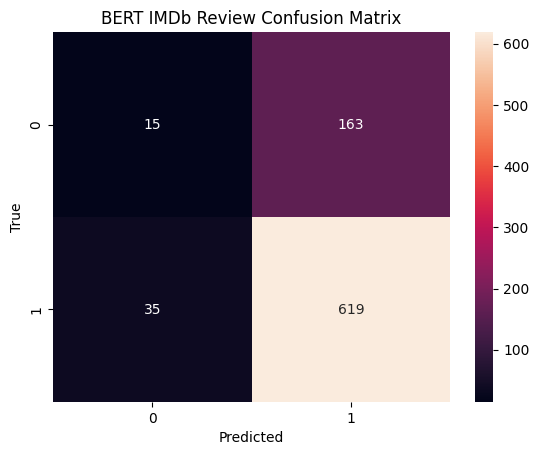

In [8]:
import seaborn as sns, matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

preds = trainer.predict(ds["test"]).predictions.argmax(-1)
cm = confusion_matrix(test_df["label"], preds)
sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("BERT IMDb Review Confusion Matrix")
plt.show()


In [9]:
model.save_pretrained("bert-imdb-sentiment/best")
tok.save_pretrained("bert-imdb-sentiment/best")


('bert-imdb-sentiment/best\\tokenizer_config.json',
 'bert-imdb-sentiment/best\\special_tokens_map.json',
 'bert-imdb-sentiment/best\\vocab.txt',
 'bert-imdb-sentiment/best\\added_tokens.json',
 'bert-imdb-sentiment/best\\tokenizer.json')

In [11]:
from transformers import pipeline
sent_classifier = pipeline("sentiment-analysis",
                           model="bert-imdb-sentiment/best",
                           tokenizer="bert-imdb-sentiment/best")

sent_classifier("Surprisingly heartfelt—and easily the worst show this year!")


Device set to use cuda:0


[{'label': 'LABEL_0', 'score': 0.7950043678283691}]

In [ ]:
# Sarcastic & Subtle Negative

sent_classifier("Oh, The Golden Age of Dragons! I had such high hopes for this one, and it certainly delivered... on being consistently mediocre. The CGI dragons looked truly fine, if you like your mythical beasts resembling glorified frisbees. And the plot? Well, it was a bold choice to prioritize endless political chatter over, you know, actual dragon-related action. A masterclass in wasted potential, really.")

# failed

[{'label': 'LABEL_1', 'score': 0.8860654830932617}]

In [ ]:
# Mixed Emotions / Contradictory

sent_classifier("While the acting in Crime City Confidential was genuinely captivating, carrying scenes that had no business being watchable, the writing felt like it was generated by a malfunctioning bot. So, you'll be alternately mesmerized by the performances and infuriated by the nonsensical plot twists. A truly frustrating yet undeniably engaging experience.")

[{'label': 'LABEL_1', 'score': 0.9044130444526672}]

In [ ]:
# Ambiguous / Implied Negative

sent_classifier("I wouldn't say Family Ties Revisited was bad, per se. It just... existed. Like a comfortable, slightly dusty old sweater you find in the back of your closet. It won't offend anyone, but it won't  exactly thrill them either. If you have absolutely nothing else to watch, and a fondness for nostalgia, then by all means.")

[{'label': 'LABEL_1', 'score': 0.9138622879981995}]